In [1]:
import os
import sys
import time
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path
from datetime import datetime
from model_settings import ms
os.chdir(os.path.abspath(str(Path())))
pd.set_option("display.max_columns",None)
pd.options.display.float_format = '{:.5f}'.format
notebook_dir = str(Path().resolve())
sys.path.append(os.path.join(notebook_dir,'historical_data','historical_generation'))
train_start = time.time()
train_start_datetime = datetime.fromtimestamp(train_start)
train_start_tag = train_start_datetime.strftime('%c')
print("\n"+"#"*18+"\n# training start #\n"+
      "#"*18+"\n"+f"\n{train_start_tag}\n")


##################
# training start #
##################

Sun Oct 27 21:39:26 2024



# loading data

In [2]:
root = Path().resolve().parent.parent
datadir = os.path.join(root,ms.cboe_spx_intraday_barriers['dump'])
files = [f for f in os.listdir(datadir) if f.endswith('.csv')]
files = [os.path.join(datadir,f) for f in files]
dfs = []
bar = tqdm(total=len(files)+1)
for f in files:
    dfs.append(pd.read_csv(f).iloc[:,1:])
    bar.update(1)
dataset = pd.concat(dfs,ignore_index=True).dropna().reset_index(drop=True)
bar.update(1)
bar.close()

100%|███████████████████████████████████████████████████████████████████████████████| 388/388 [00:01<00:00, 217.95it/s]


In [3]:
from quantlib_pricers import vanilla_pricer
vanillas = vanilla_pricer()
dataset['calculation_date'] = pd.to_datetime(dataset['calculation_date'],format='%Y-%m-%d %H:%M:%S')


initializing vanilla pricer
Actual/365 (Fixed) day counter
seed: 123



# model specification

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer, OneHotEncoder

from convsklearn import asian_trainer, barrier_trainer
price = 'barrier_price' 
filetag = 'intraday barrier options'
trainer = barrier_trainer

trainer.activation_function = 'relu'
trainer.max_iter = 1000
trainer.solver = 'sgd'
trainer.target_transformer_pipeline = Pipeline(steps=[('PowerTransformer', PowerTransformer())])
trainer.target_trainsformers = [
    ('PowerTransformer',PowerTransformer(),
        [
            'spot_price',
            'strike_price',
            'days_to_maturity',
            'risk_free_rate',
            'dividend_rate',
            'kappa',
            'theta',
            'rho',
            'eta',
            'v0',
            'barrier'
        ]
    ),
    ('OneHotEncoder',OneHotEncoder(sparse_output=False),['barrier_type_name', 'w'])
]
trainer.__dict__

{'target_name': 'observed_price',
 'numerical_features': ['spot_price',
  'strike_price',
  'days_to_maturity',
  'risk_free_rate',
  'dividend_rate',
  'kappa',
  'theta',
  'rho',
  'eta',
  'v0',
  'barrier'],
 'categorical_features': ['barrier_type_name', 'w'],
 'feature_set': ['spot_price',
  'strike_price',
  'days_to_maturity',
  'risk_free_rate',
  'dividend_rate',
  'kappa',
  'theta',
  'rho',
  'eta',
  'v0',
  'barrier',
  'barrier_type_name',
  'w'],
 'random_state': None,
 'max_iter': 1000,
 'n_layers': None,
 'layer_size': 13,
 'hidden_layer_sizes': (13, 13, 13),
 'solver': 'sgd',
 'alpha': 0.0001,
 'learning_rate': 'adaptive',
 'activation_function': 'relu',
 'rf_n_estimators': 50,
 'rf_min_samples_leaf': 2000,
 'transformers': [('StandardScaler',
   StandardScaler(),
   ['spot_price',
    'strike_price',
    'days_to_maturity',
    'risk_free_rate',
    'dividend_rate',
    'kappa',
    'theta',
    'rho',
    'eta',
    'v0',
    'barrier']),
  ('OneHotEncoder',
   On

# preprocessing

In [5]:
dataset[price] = pd.to_numeric(dataset[price],errors='coerce')
dataset['observed_price'] = np.maximum(dataset[price] + np.random.normal(scale=(0.15)**2,size=dataset.shape[0]),0)
dataset['calculation_date'] = pd.to_datetime(dataset['calculation_date'])
dataset = dataset.sort_values(by='calculation_date')
dataset = dataset.dropna().reset_index(drop=True)
dataset

,spot_price,strike_price,barrier,days_to_maturity,updown,outin,w,barrier_type_name,rebate,dividend_rate,risk_free_rate,theta,kappa,rho,eta,v0,calculation_date,barrier_price,observed_price
0,1281.35021,1153.21519,640.67510,60,Down,Out,call,DownOut,0.00000,0.00000,0.04000,0.08980,3.34629,-0.63560,1.97773,0.04478,2012-01-03 10:00:00,147.74297,147.71932
1,1281.35021,1249.31645,1294.16371,180,Up,Out,call,UpOut,0.00000,0.00000,0.04000,0.08980,3.34629,-0.63560,1.97773,0.04478,2012-01-03 10:00:00,0.15548,0.16049
2,1281.35021,1249.31645,1294.16371,90,Up,In,put,UpIn,0.00000,0.00000,0.04000,0.08980,3.34629,-0.63560,1.97773,0.04478,2012-01-03 10:00:00,25.47974,25.46395
3,1281.35021,1249.31645,1294.16371,90,Up,In,call,UpIn,0.00000,0.00000,0.04000,0.08980,3.34629,-0.63560,1.97773,0.04478,2012-01-03 10:00:00,77.26336,77.28756
4,1281.35021,1249.31645,1294.16371,90,Up,Out,put,UpOut,0.00000,0.00000,0.04000,0.08980,3.34629,-0.63560,1.97773,0.04478,2012-01-03 10:00:00,7.92415,7.95693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835915,1463.47190,1500.05870,1448.83719,360,Down,In,put,DownIn,0.00000,0.00000,0.04000,0.03327,8.43589,-0.46386,2.56961,0.00901,2013-01-04 12:00:00,71.93304,71.93038
835916,1463.47190,1500.05870,1448.83719,360,Down,In,call,DownIn,0.00000,0.00000,0.04000,0.03327,8.43589,-0.46386,2.56961,0.00901,2013-01-04 12:00:00,70.59967,70.60306
835917,1463.47190,1500.05870,1448.83719,360,Down,Out,put,DownOut,0.00000,0.00000,0.04000,0.03327,8.43589,-0.46386,2.56961,0.00901,2013-01-04 12:00:00,0.04819,0.04318
835918,1463.47190,1536.64550,731.73595,60,Down,In,put,DownIn,0.00000,0.00000,0.04000,0.03327,8.43589,-0.46386,2.56961,0.00901,2013-01-04 12:00:00,0.26049,0.30289


## train/test split

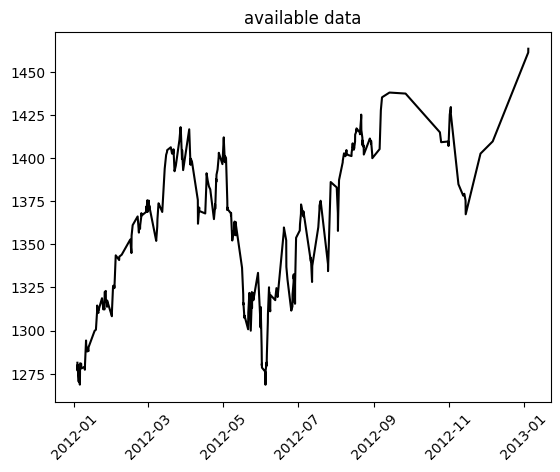

In [6]:
plt.figure
plt.plot(dataset[['calculation_date','spot_price']].drop_duplicates().set_index('calculation_date'),color='black')
plt.title('available data')
plt.xticks(rotation=45)
plt.show()
unique_dates = dataset['calculation_date'].unique()

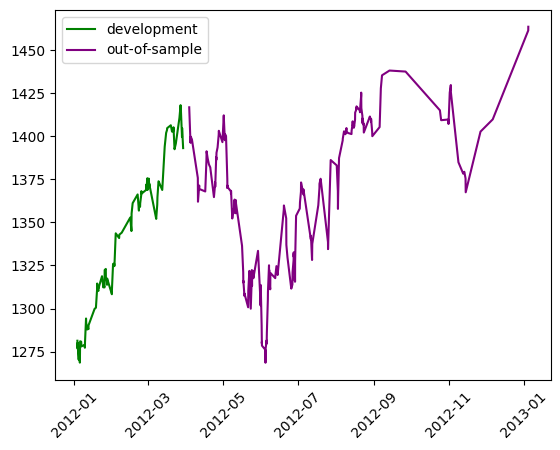

In [7]:
# development_dates = unique_dates[unique_dates<=pd.Timestamp(2008,9,1)]
development_dates = unique_dates[:len(unique_dates)//3]
test_dates = unique_dates[~unique_dates.isin(development_dates)]
train_data = dataset[dataset['calculation_date'].isin(development_dates)]
test_data = dataset[dataset['calculation_date'].isin(test_dates)]
plt.figure()
plt.xticks(rotation=45)
plt.plot(train_data[['calculation_date','spot_price']].copy().drop_duplicates().set_index('calculation_date'),color='green',label='development')
plt.plot(test_data[['calculation_date','spot_price']].copy().drop_duplicates().set_index('calculation_date'),color='purple',label='out-of-sample')
plt.legend()
plt.show()

In [8]:
arrs = trainer.get_train_test_arrays(
    train_data, test_data)
preprocessor = trainer.preprocess()
train_X = arrs['train_X'] 
train_y = arrs['train_y']
test_X = arrs['test_X']
test_y = arrs['test_y']

# training

In [9]:
model_fit, runtime, specs = trainer.run_dnn(preprocessor,train_X,train_y)
train_end = time.time()
train_runtime = train_end-train_start
print(f"\ncpu: {train_runtime}")


training...

Deep Neural Network
hidden layers sizes: (13, 13, 13)
learning rate: adaptive
activation: relu
solver: sgd
alpha: 0.0001

cpu: 65.88525533676147


# testing

In [10]:
model_fit

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      ColumnTransformer(transformers=[('StandardScaler',
                                                                                       StandardScaler(),
                                                                                       ['spot_price',
                                                                                        'strike_price',
                                                                                        'days_to_maturity',
                                                                                        'risk_free_rate',
                                                                                        'dividend_rate',
                                                                                        'kappa',
                                                                                        'theta',
                                                                                        'rho',
                                                                                        'eta',
                                                                                        'v0',
                                                                                        'barrier']),
                                                                                      ('OneHotEncoder',
                                                                                       OneHotEncoder(sparse_output=False),
                                                                                       ['barrier_type_name',
                                                                                        'w'])])),
                                                     ('regressor',
                                                      MLPRegressor(hidden_layer_sizes=(13,
                                                                                       13,
                                                                                       13),
                                                                   learning_rate='adaptive',
                                                                   max_iter=1000,
                                                                   solver='sgd'))]),
                           transformer=Pipeline(steps=[('PowerTransformer',
                                                        PowerTransformer())]))

In [11]:
insample, outsample, errors = trainer.test_prediction_accuracy(
        model_fit,
        test_data,
        train_data
)
outofsample_RMSE = errors['outofsample_RMSE']


in sample:
     RMSE: 9.604504836637997
     MAE: 5.503060016323

out of sample:
     RMSE: 11.386014643485211
     MAE: 6.3372685386471375


# saving

In [12]:
train_end_tag = str(datetime.fromtimestamp(
    train_end).strftime("%Y_%m_%d %H-%M-%S"))
file_tag = str(train_end_tag + " " + specs[0] + " " + filetag)
os.chdir(os.path.join(notebook_dir,'trained_models'))
files_dir = os.path.join(
    notebook_dir,'trained_models','trained_models',
    file_tag)

def save_model():
    if Path(files_dir).exists():
        pass
    else:
        os.mkdir(files_dir)
    file_dir = os.path.join(files_dir,file_tag)
    S = np.sort(train_data['spot_price'].unique())
    K = np.sort(train_data['strike_price'].unique())
    T = np.sort(train_data['days_to_maturity'].unique())
    W = np.sort(train_data['w'].unique())
    n_calls = train_data[train_data['w']=='call'].shape[0]
    n_puts = train_data[train_data['w']=='put'].shape[0]
    insample.to_csv(f"{file_dir} insample.csv")
    outsample.to_csv(f"{file_dir} outsample.csv")
    joblib.dump(model_fit,str(f"{file_dir}.pkl"))
    pd.set_option("display.max_columns",None)
    
    with open(f'{file_dir}.txt', 'w') as file:
        file.write(train_start_tag)
        file.write(f"\nspot(s):\n{S}")
        file.write(f"\n\nstrikes:\n{K}\n")
        file.write(f"\nmaturities:\n{T}\n")
        file.write(f"\ntypes:\n{W}\n")
        try:
            file.write(f"\n{train_data['barrier_type_name'].unique()}")
        except Exception:
            pass
        try:
            for col in ['averaging_type','fixing_frequency','past_fixings','n_fixings']:
                file.write(f"\n{col}:")
                file.write(f"\n{dataset[col].drop_duplicates().sort_values().values}\n")
        except Exception:
            pass
        file.write(f"\nnumber of calls, puts:\n{n_calls},{n_puts}\n")
        file.write(f"\ntotal prices:\n{train_data.shape[0]}\n")
        for spec in specs:
            file.write(f"{spec}\n")
        file.write("#"*17+"\n# training data #\n"+"#"*17+
              f"\n{train_data.describe()}\n")
        file.write("#"*13+"\n# test data #\n"+"#"*13+
              f"\n{test_data.describe()}\n")
        file.write(f"\n{dataset.dtypes}")
        file.write(
            f"\nin sample results:"
            f"\n     RMSE: {errors['insample_RMSE']}"
            f"\n     MAE: {errors['insample_MAE']}\n"
            f"\nout of sample results:"
            f"\n     RMSE: {errors['outofsample_RMSE']}"
            f"\n     MAE: {errors['outofsample_MAE']}\n"
            )
        file.write("\nfeatures:\n")
        for feature in trainer.feature_set:
            file.write(f"     {feature}\n")
        file.write(f"\ntarget: {trainer.target_name}\n")
        file.write(f"\ncpu: {train_runtime}\n")
        file.write(datetime.fromtimestamp(train_end).strftime('%c'))
        print(f"model saved to {file_dir}")

print(f"execute the command 'save_model()' to save the following model: {file_tag}")

execute the command 'save_model()' to save the following model: 2024_10_27 21-40-32 Deep Neural Network intraday barrier options
